In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"
spk_path = os.path.join(base_path, "model_runs")
vc_path = os.path.join(base_path, "vc_runs")
fig_path = os.path.join(base_path, "erm2023_figs")
os.makedirs(fig_path, exist_ok=True)

In [4]:
ctrl_spk_name = "decr_conf_5ms_step_weight_x2_Na0p035_K0p035_order2"
expr_spk_name = "decr_conf_5ms_step_weight_x2_Na0p035_K0p035_order2_plex3"
ctrl_vc_name =  "ctrl_5ms_step_weight_x2_order2"
expr_vc_name =  "plex3_5ms_step_weight_x2_order2"

ctrl_lbl = "ctrl"
expr_lbl = "plex"

ctrl_spk_hdf = h5.File(os.path.join(spk_path, ctrl_spk_name) + ".h5", "r")
ctrl_vc_hdf =  h5.File(os.path.join(vc_path, ctrl_vc_name) + ".h5", "r")
expr_spk_hdf = h5.File(os.path.join(spk_path, expr_spk_name) + ".h5", "r")
expr_vc_hdf =  h5.File(os.path.join(vc_path, expr_vc_name) + ".h5", "r")

hdfs = {
    ctrl_lbl: {"spk": ctrl_spk_hdf, "vc": ctrl_vc_hdf},
    expr_lbl: {"spk": expr_spk_hdf, "vc": expr_vc_hdf},
}
d = {
    lbl: {rec: Workspace(hdf, read_only=True) for rec, hdf in exp.items()}
    for lbl, exp in hdfs.items()
}
ctrl = d[ctrl_lbl]
expr = d[expr_lbl]

exps = list(d.keys())
rhos = list(ctrl["vc"].keys())
idxs = list(ctrl["vc"][rhos[0]].keys())
print("==keys==")
print("exps:", exps)
print("rhos:", rhos)
print("idxs:", idxs)
print("spk data keys:", list(ctrl["spk"][rhos[0]][idxs[0]].keys()))
print("vc data keys:", list(ctrl["vc"][rhos[0]][idxs[0]].keys()))

==keys==
exps: ['ctrl', 'plex']
rhos: [0.0, 1.0]
idxs: [0, 1, 2, 3, 4, 5]
spk data keys: ['dendrites', 'metrics', 'params', 'sac_net', 'soma', 'syn_locs']
vc data keys: ['params', 'sac_net', 'soma', 'syn_locs']


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for exp in d.values():
                for wrk in exp.values():
                    wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
metrics = {exp: ana.get_sac_metrics(wrk["spk"]) for exp, wrk in d.items()}

dir_labels = ctrl["spk"][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = {exp: ana.get_sac_thetas(wrk["spk"]) for exp, wrk in d.items()}
sac_deltas = {exp: ana.get_sac_deltas(ts) for exp, ts in sac_thetas.items()} 

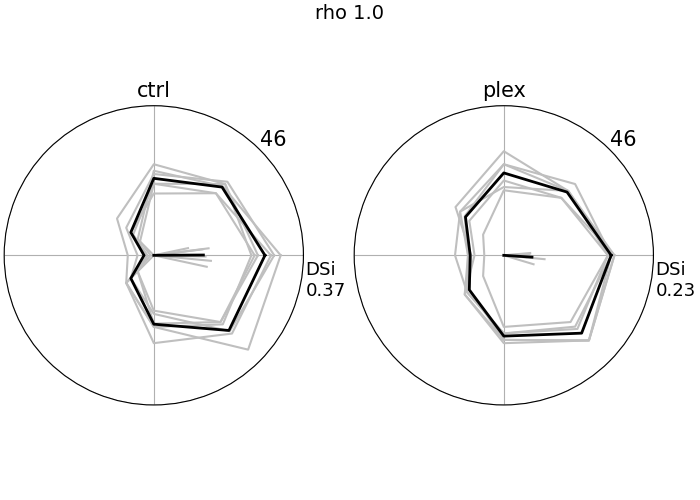

In [7]:
rho = 1.0

max_spikes = np.max([r["spikes"] for ms in metrics.values() for r in ms.values()])
focus_polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(exps)
focus_polar_ax = [
    polar_plot(
        m[rho],
        dir_labels,
        title=exp,
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=focus_polar_fig,
        sub_loc=(1, n_cols, loc + 1),
        title_metrics=False,
    )
    for loc, (exp, m) in enumerate(metrics.items())
]
focus_polar_fig.suptitle("rho %.1f" % rho, fontsize=14)
focus_polar_fig.set_layout_engine("compressed")
focus_polar_fig.savefig(
    os.path.join(fig_path, "rho%.1f_polars.png" % rho), bbox_inches="tight", transparent=False)

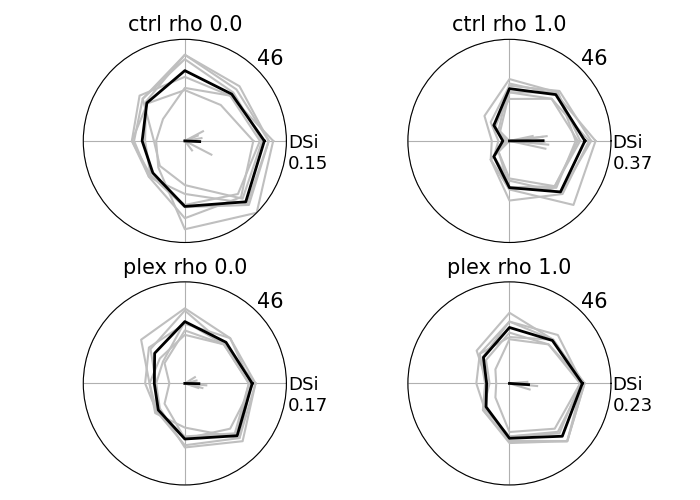

In [8]:
# show_rhos = list(metrics.keys())
show_rhos = [0.0, 1.0]
# show_rhos = [0.0, 0.9, 0.96, 0.99, 1.0]
show_exps = exps

max_spikes = np.max([metrics[exp][r]["spikes"] for exp in show_exps for r in show_rhos])
polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(show_rhos)
n_rows = len(show_exps)
polar_ax = [
    polar_plot(
        metrics[exp][r],
        dir_labels,
        title="%s rho %s" % (exp, str(r)),
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=polar_fig,
        sub_loc=(n_rows, n_cols, row * n_cols + loc + 1),
        title_metrics=False,
    )
    for row, exp in enumerate(show_exps) 
    for loc, r in enumerate(show_rhos)
]
polar_fig.tight_layout()

rho_lbl = str(show_rhos)[1:-1].replace(", ", "_").replace(".", "p")
for ext in [".png", ".svg"]:
    name = os.path.join(fig_path, "polar_%s%s" % (rho_lbl, ext))
    polar_fig.savefig(name, bbox_inches="tight", transparent=False)

In [22]:
rho_dsis = {exp: np.stack([ms[r]["DSis"] for r in rhos], axis=0) for exp, ms in metrics.items()}
rho_net_avg_dsis = {exp: np.mean(dsis, axis=2) for exp, dsis in rho_dsis.items()}
rho_net_std_dsis = {exp: np.std(avgs, axis=1) for exp, avgs in rho_net_avg_dsis.items()}
rho_spks = {
    exp: np.stack([ms[r]["spikes"].transpose(2, 0, 1) for r in rhos], axis=0)
    for exp, ms in metrics.items()
}
rho_net_avg_spks = {exp: np.mean(spks, axis=3) for exp, spks in rho_spks.items()}
rho_net_std_spks = {exp: np.std(avgs, axis=2) for exp, avgs in rho_net_avg_spks.items()}
rho_avg_dsis = {exp: np.array([np.mean(ms[r]["avg_DSi"]) for r in rhos]) for exp, ms in metrics.items()}
rho_avg_spks = {
    exp: np.stack([np.mean(ms[r]["spikes"], axis=(0, 1)) for r in rhos], axis=0)
    for exp, ms in metrics.items()
}

# def rho_plot_dir(row, dir_idx):
#     rho_range_ax[row].fill_between(
#         rhos,
#         rho_avg_spks[:, dir_idx] + rho_net_std_spks[:, dir_idx],
#         rho_avg_spks[:, dir_idx] - rho_net_std_spks[:, dir_idx],
#         alpha=0.2,
#     )
#     rho_range_ax[row].plot(rhos, rho_avg_spks[:, dir_idx])
#     rho_range_ax[row].set_ylabel("Spikes in %i" % dir_labels[dir_idx], fontsize=13)
    
# rho_range_fig, rho_range_ax = plt.subplots(4, sharex=True, figsize=(4, 6))
# rho_range_ax[0].fill_between(
#     rhos,
#     rho_avg_dsis + rho_net_std_dsis,
#     rho_avg_dsis - rho_net_std_dsis,
#     alpha=0.2,
# )
# rho_range_ax[0].plot(rhos, rho_avg_dsis)
# rho_plot_dir(1, 6) # 135
# rho_plot_dir(2, 7) # 180
# rho_plot_dir(3, 0) # 225
# rho_range_ax[0].set_ylabel("DSi", fontsize=13)
# rho_range_ax[-1].set_xlabel("rho", fontsize=13)
# clean_axes(rho_range_ax)
# rho_range_fig.tight_layout()

# for ext in [".png", ".svg"]:
#     rho_range_fig.savefig(os.path.join(fig_path, "rho_range" + ext), bbox_inches="tight")

In [10]:
# show_rhos = list(metrics.keys())
# show_rhos = [0.0, 1.0]
# show_tuning = {r: tuning[r] for r in show_rhos}
# scatter_fig = ds_scatter(show_tuning, figsize=(7, 4))
# scatter_fig.tight_layout()

In [11]:
# dir_field_offsets = [10.9, 25.7, 36.4, 22.5, 6.6, 5.6, 1.1, 0.]  # ms
# rho = 0. 
# rasters_fig = spike_rasters(
#     d,
#     dir_labels,
#     rho=rho,
#     bin_ms=50,
#     offsets=dir_field_offsets,
#     colour="black",
#     spike_vmax=700,
#     figsize=(8, 7),
# )
# name = os.path.join(fig_path, "rasters_%s" % ("%.2f" % rho).replace(".", "p"))
# for ext in [".png", ".svg"]:
#     rasters_fig.savefig(name + ext, bbox_inches="tight")

In [12]:
vc_transmitters = list(ctrl["vc"][rhos[0]][idxs[0]]["soma"].keys())
vc_params = ctrl["vc"][rhos[0]][idxs[0]]["params"]
vc_xaxis = np.arange(int(vc_params["tstop"] / vc_params["dt"]) + 1) * vc_params["dt"]

In [13]:
vc_trial_avgs = {
    exp: {
        rho: {
            n: {trans: np.mean(rec, axis=0) for trans, rec in net["soma"].items()}
            for n, net in nets.items()
        }
        for rho, nets in wrk["vc"].items()      
    }
    for exp, wrk in d.items()
}
    
vc_net_avgs = {
    exp: {
        rho: {
            trans: np.mean([net[trans] for net in nets.values()], axis=0)
            for trans in vc_transmitters
        }
        for rho, nets in avgs.items()
    }
    for exp, avgs in vc_trial_avgs.items()
}

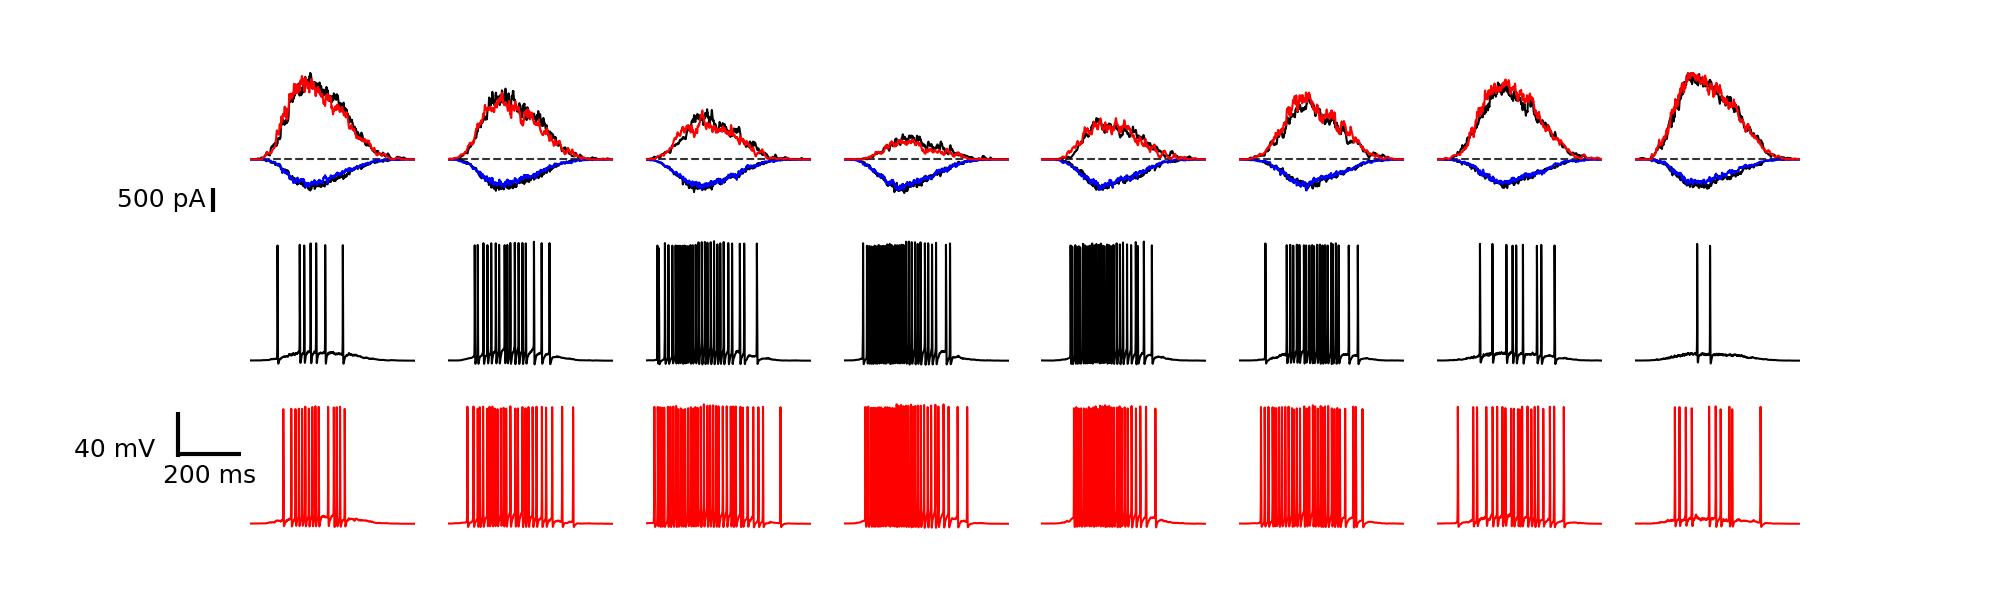

In [21]:
rho = 1.0
net = 0
trial = 0
vm_t0 = 300
vc_mode = "trial"  # net_avg, trial_avg, or trial (default)

if vc_mode == "net_avg":
    get_vc = lambda lbl, rho, trans: vc_net_avgs[lbl][rho][trans]
elif vc_mode == "trial_avg":
    get_vc = lambda lbl, rho, trans: vc_trial_avgs[lbl][rho][net][trans]
else:
    get_vc = lambda lbl, rho, trans: d[lbl]["vc"][rho][net]["soma"][trans][trial]
    
trial_vm_vc_fig, trial_vm_vc_ax = plt.subplots(
    1 + len(exps), len(dir_labels), sharex=True, sharey="row", figsize=(20, 6))

for i, ax in enumerate(trial_vm_vc_ax[0]):
    ax.plot([vc_xaxis[0], vc_xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)
    ax.plot(vc_xaxis, get_vc(ctrl_lbl, rho, "E")[i], c="black")
    ax.plot(vc_xaxis, get_vc(ctrl_lbl, rho, "GABA")[i], c="black")
    ax.plot(vc_xaxis, get_vc(expr_lbl, rho, "E")[i], c="blue")
    ax.plot(vc_xaxis, get_vc(expr_lbl, rho, "GABA")[i], c="red")
    ax.patch.set_alpha(0)

vc_sb = add_scalebar(
    trial_vm_vc_ax[0, 0], 
    matchx=False, 
    matchy=False, 
    # sizey=1.5, 
    # labely="1.5 nA",
    sizey=0.5, 
    labely="500 pA",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 400),
    textprops={"fontsize": 18},
)

vm_pts = ctrl["spk"][rho][net]["soma"]["Vm"].shape[-1] 
vm_xaxis = np.linspace(0, vm_pts * ctrl["spk"][rho][net]["params"]["dt"], vm_pts)

ctrl_clr = "black"
expr_clr = "red"
for i, exp in enumerate(exps): 
    clr = expr_clr if i else ctrl_clr
    for j in range(len(dir_labels)):
        trial_vm_vc_ax[i + 1, j].plot(
            vm_xaxis[vm_t0:], d[exp]["spk"][rho][net]["soma"]["Vm"][trial, j, vm_t0:], c=clr)
        trial_vm_vc_ax[i + 1, j].patch.set_alpha(0)

sizex = 200
sizey = 40
vm_sb = add_scalebar(
    trial_vm_vc_ax[1, 0], 
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % sizex,
    labely="%i mV" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 150),
    textprops={"fontsize": 18},
)

clean_axes(trial_vm_vc_ax, remove_spines=["left", "right", "top", "bottom"])
trial_vm_vc_ax[0, 0].set_ylim(-1, 1.8)
trial_vm_vc_ax[0, 0].set_xlim(vm_xaxis[vm_t0], vm_xaxis[-1])

name = os.path.join(fig_path, "vm_rho%s_net%i_trial%i" % (("%.2f" % rho).replace(".", "p"), net, trial))
for ext in [".png", ".svg"]:
    trial_vm_vc_fig.savefig(name + ext, transparent=True)

In [15]:
close_button()